## Data loading and Cleaning

In [25]:
import pandas as pd
import ast

# Load the dataset
df = pd.read_csv('hwc_events.csv')

# Extract latitude and longitude from the 'location' column
df['location'] = df['location'].apply(ast.literal_eval)
df['latitude'] = df['location'].apply(lambda x: x['latitude'])
df['longitude'] = df['location'].apply(lambda x: x['longitude'])

# Filter for lion-related events
lion_events = df[df['event_details__hwcrep_species'] == 'lion']

# Convert 'time' to datetime using ISO8601 format
lion_events['time'] = pd.to_datetime(lion_events['time'], format='ISO8601')

# Check the result
lion_events[['time', 'latitude', 'longitude']].head()

C:\Users\Pro\AppData\Local\Temp\ipykernel_21932\4099257340.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_events['time'] = pd.to_datetime(lion_events['time'], format='ISO8601')


,time,latitude,longitude
14,2024-03-05 08:10:00+03:00,-1.323395,35.144538
18,2024-03-08 09:42:54+03:00,-1.319043,35.146232
19,2024-03-09 19:00:00+03:00,-1.087949,35.295242
26,2024-03-16 09:49:00+03:00,-1.711653,35.428010
40,2024-04-08 02:00:00+03:00,-1.045439,35.352031


In [26]:
# Check the data types
lion_events.dtypes


id                                                                 object
location                                                           object
time                                            datetime64[ns, UTC+03:00]
end_time                                                          float64
message                                                           float64
provenance                                                        float64
event_type                                                         object
priority                                                            int64
priority_label                                                     object
attributes                                                         object
comment                                                           float64
title                                                             float64
state                                                              object
sort_at                               

## interactive Map for the Human Wildlife Conflicts

In [27]:
import folium
from folium.plugins import HeatMap

# Create a map centered on Maasai Mara
mara_map = folium.Map(location=[-1.5, 35.0], zoom_start=10, tiles='CartoDB positron')

# Add markers for lion conflicts
for idx, row in lion_events.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='red',
        fill=True,
        popup=f"Date: {row['time'].date()}<br>Livestock: {row['event_details__hwcrep_livestocktypes']}"
    ).add_to(mara_map)

# Display the map inline
mara_map

## Hotspot Analysis in Contours

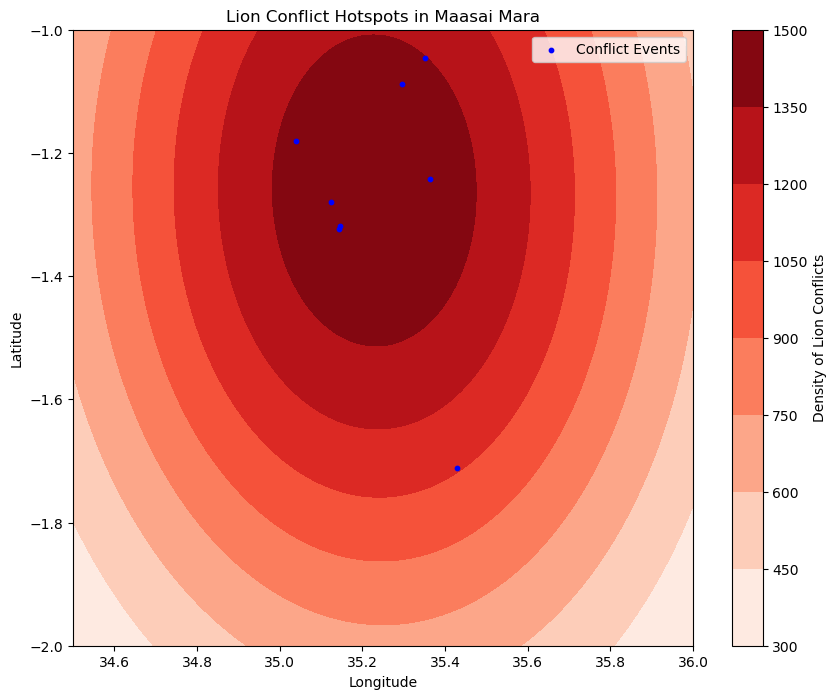

In [28]:
from sklearn.neighbors import KernelDensity
import numpy as np

# Prepare data for KDE
coords = lion_events[['latitude', 'longitude']].values

# Perform KDE
kde = KernelDensity(bandwidth=0.01, metric='haversine')
kde.fit(np.radians(coords))

# Generate a grid for visualization
xgrid, ygrid = np.meshgrid(np.linspace(34.5, 36.0, 100), np.linspace(-2.0, -1.0, 100))
grid_coords = np.column_stack([ygrid.ravel(), xgrid.ravel()])
density = np.exp(kde.score_samples(np.radians(grid_coords)))

# Plot the density
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.contourf(xgrid, ygrid, density.reshape(xgrid.shape), cmap='Reds')
plt.colorbar(label='Density of Lion Conflicts')
plt.scatter(coords[:, 1], coords[:, 0], c='blue', s=10, label='Conflict Events')
plt.title('Lion Conflict Hotspots in Maasai Mara')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

## Hotspot Analysis using Heatmaps

In [29]:
# Extract coordinates for heatmap
heatmap_data = lion_events[['latitude', 'longitude']].values.tolist()

# Create a heatmap layer
heatmap = HeatMap(heatmap_data, radius=15, blur=20)

# Add heatmap to the map
mara_heatmap = folium.Map(location=[-1.5, 35.0], zoom_start=10, tiles='CartoDB positron')
heatmap.add_to(mara_heatmap)

# Display the heatmap
mara_heatmap

* High-density areas (red) indicate conflict hotspots, likely near livestock grazing zones or migration corridors.

## Temporal Analysis

C:\Users\Pro\AppData\Local\Temp\ipykernel_21932\1229549578.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  lion_events['month'] = lion_events['time'].dt.to_period('M')
C:\Users\Pro\AppData\Local\Temp\ipykernel_21932\1229549578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_events['month'] = lion_events['time'].dt.to_period('M')


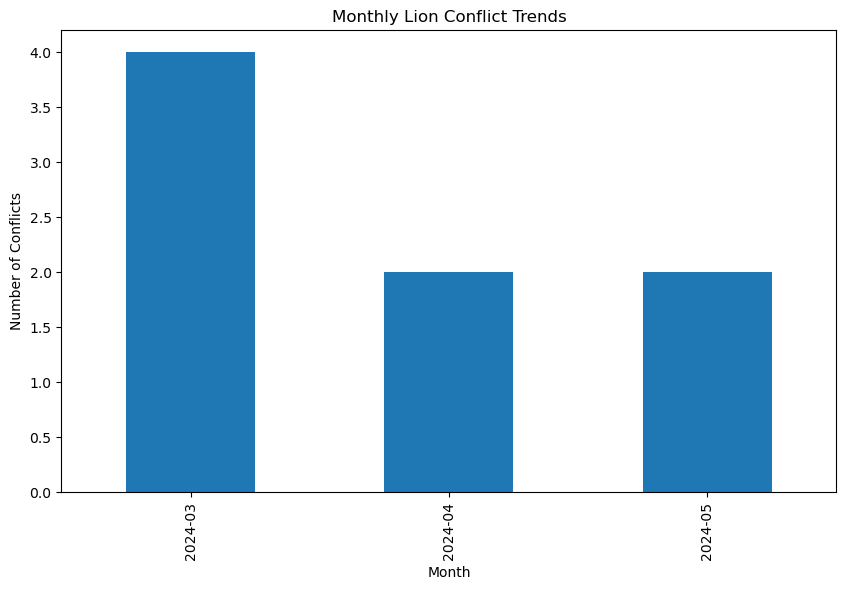

In [30]:
# Group by month and count events
lion_events['month'] = lion_events['time'].dt.to_period('M')
monthly_counts = lion_events.groupby('month').size()

# Plot monthly trends
monthly_counts.plot(kind='bar', figsize=(10, 6), title='Monthly Lion Conflict Trends')
plt.xlabel('Month')
plt.ylabel('Number of Conflicts')
plt.show()

## Livestock Analysis

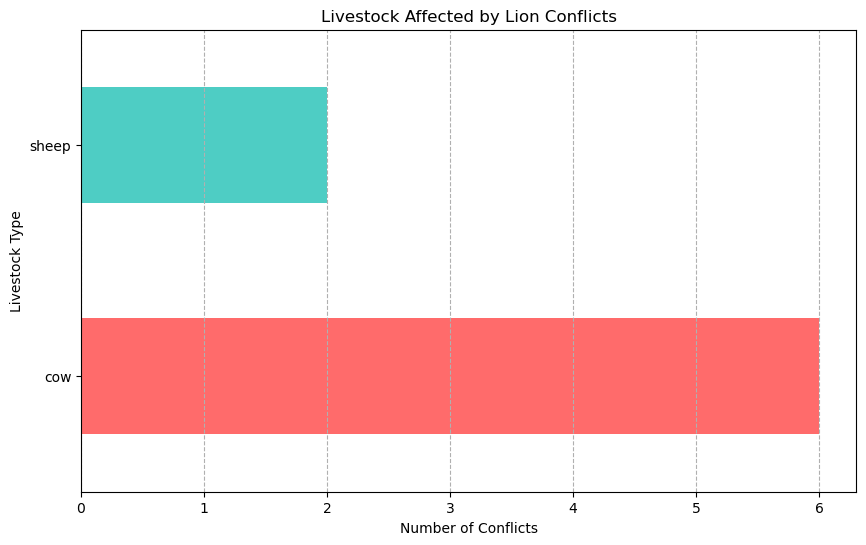

In [34]:
# Group by livestock type
livestock_impact = lion_events.groupby('event_details__hwcrep_livestocktypes').size()

# Plot livestock impact
plt.figure(figsize=(10, 6))
livestock_impact.plot(kind='barh', color=['#ff6b6b','#4ecdc4'])
plt.title('Livestock Affected by Lion Conflicts')
plt.xlabel('Number of Conflicts')
plt.ylabel('Livestock Type')
plt.grid(axis='x', linestyle='--')
plt.show()

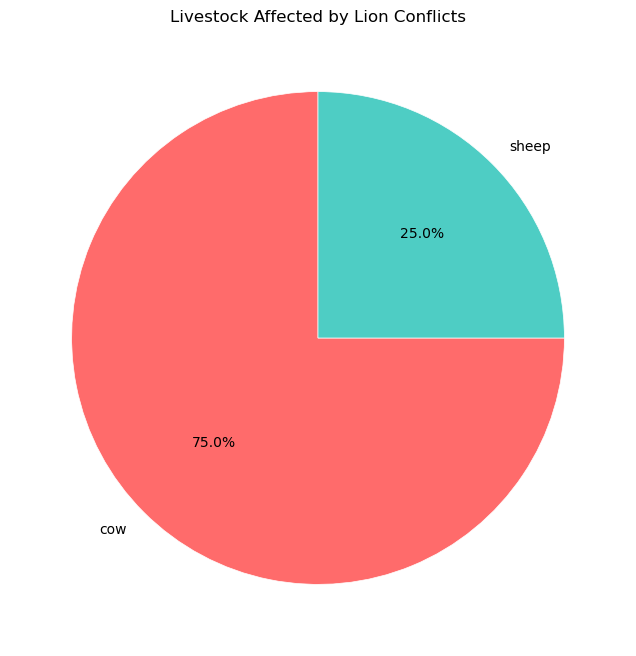

In [ ]:
# Group data by livestock type
livestock_counts = lion_events['event_details__hwcrep_livestocktypes'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    livestock_counts,
    labels=livestock_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#ff6b6b', '#4ecdc4', '#45b7d1'],
    wedgeprops={'edgecolor': 'white', 'linewidth': 0.5}
)
plt.title('Livestock Affected by Lion Conflicts')
plt.show()

# Interpretation

1. Hotspots: Conflicts cluster in areas with coordinates around longitude ```35.1–35.4``` and latitude ```-1.3–-1.1```

2. Temporal Trends: March 2024 saw the highest conflict frequency.

3. Livestock Impact: Cows and sheep are the most affected livestock, likely due to their economic value and grazing locations